## <div align="center">Экспериментальный анализ производительности пересечений автоматов</div>
### <div align="center">Отчет о проведении эксперимента</div>
<div align="center">23.09.20</div>

**Датасеты:**  

Использованы датасеты LUBM300, LUBM500, LUBM1M, LUBM1.5M, LUBM1.9M (запуск на других приводил к зависанию без видимого прогресса)  
Регекспы были преобразованы для использования pyformlang (спасибо Vadim Abzalov)  
**Железо:**  

Architecture:        x86_64  
CPU(s):              8  
Thread(s) per core:  2  
Model name:          Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz  
CPU MHz:             700.067  
CPU max MHz:         3400,0000  
CPU min MHz:         400,0000  
L1d cache:           32K  
L1i cache:           32K  
L2 cache:            256K  
L3 cache:            6144K   

OS: Ubuntu 18.04  
RAM: 2x4Gb DDR4

Замеры производились с помощью встроенного модуля *time*, бралось усредненное значение из 5 экспериментов.  
Контрольные числа(reachable_pairs) были проверены на совпадение на этапе постпроцессинга для каждого из алгоритмов транзитивного замыкания матриц.  
Регулярные выражения были сгруппированы в 12 наборов по структурной схожести 

In [109]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Пример итоговой таблички (для датасета LUBM500):

In [168]:
df = pandas.read_csv('res_LUBM500.csv')
df.head()

,algo,graph,regex,reachable_pairs,intersection+closure_time_ms,pairs_time_ms
0,0,LUBM500,q11_4_5,609305,285,0
1,1,LUBM500,q11_4_5,609305,298,0
2,0,LUBM500,q5_4,977995,240,0
3,1,LUBM500,q5_4,977995,188,0
4,0,LUBM500,q4_2_8,213515,60,0


Все замеры вычисления итоговых пар (терминал, количество ребер с этим терминалом) длились меньше 1 мс (кроме одного выброса)

In [148]:
table_mask = "res_LUBM{num}.csv"
for num in ['300', '500', '1M', '1.5M', '1.9M']:
    df = pandas.read_csv(table_mask.format(num=num))
    print(df['pairs_time_ms'].unique())

[0]
[0]
[0]
[0]
[0 7]


In [164]:
def boxplot(df):
    def get_box_data(df): 
        df = df.drop(['reachable_pairs', 'graph'], axis=1)
        df['regex'] = df['regex'].replace(to_replace='^q_', value='q0_', regex=True)
        for i in range(10):
            df['regex'] = df['regex'].replace(to_replace=f"^q{i}_", value=f"q0{i}_", regex=True)
        df['regex'] = df['regex'].apply(lambda regex: regex[:3])
        return df

    plt.figure(figsize=(20,10))
    df_name = df['graph'][0]
    box_df = get_box_data(df)
    bp = sns.boxplot(y='intersection+closure_time_ms', x='regex', 
                     data=box_df, 
                     palette="Paired",
                     hue='algo',
                     width=0.5,
                     order=sorted(box_df['regex'].unique()),
                )
    bp.set_title(df_name)
    bp.set_yscale("log")
    bp.set_ylabel("intersection+closure time, ms")
    leg = bp.get_legend()
    leg.texts[0].set_text('Multiplication')
    leg.texts[1].set_text('Squaring')

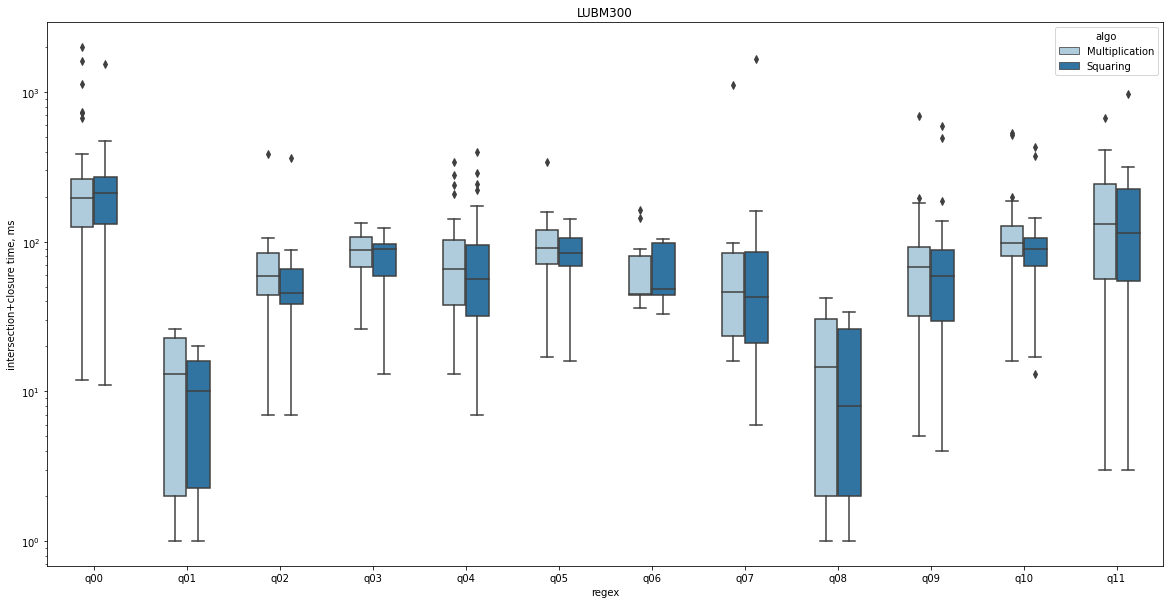

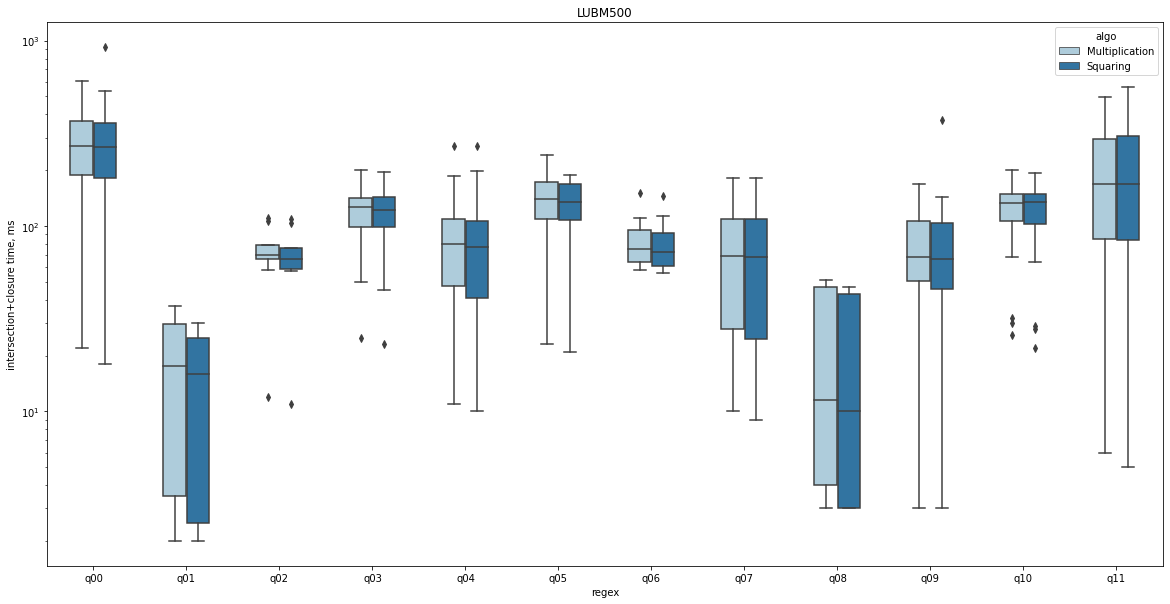

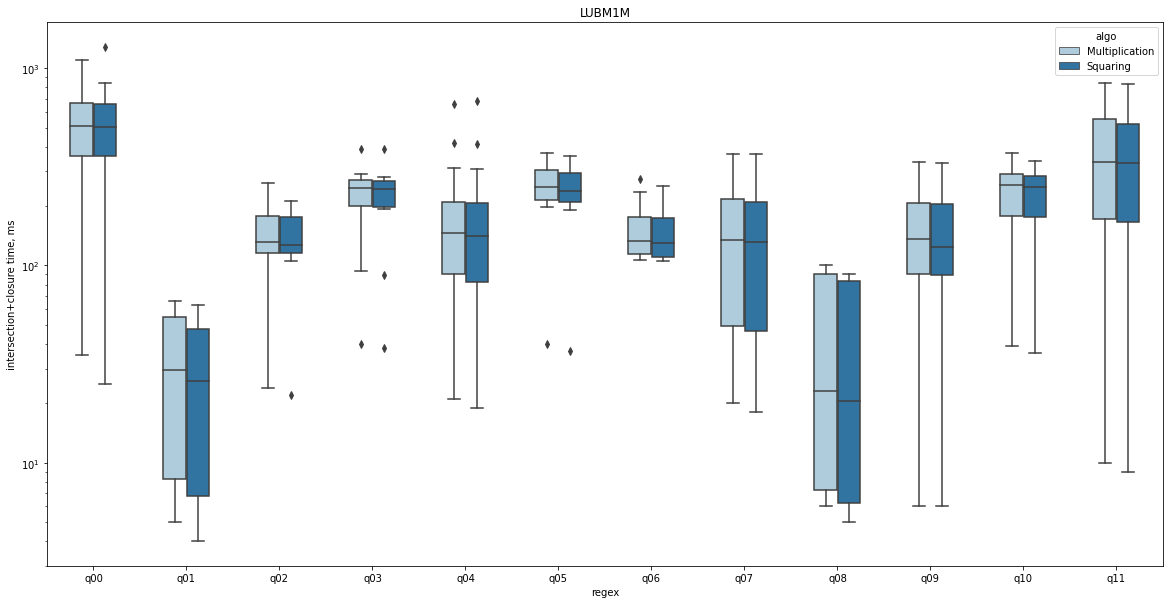

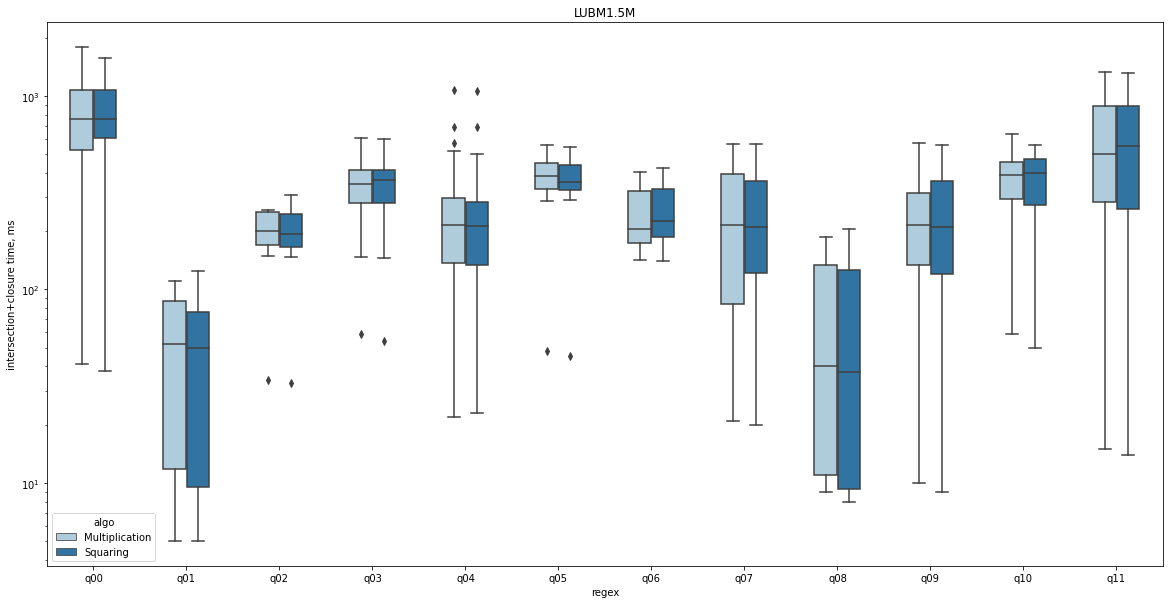

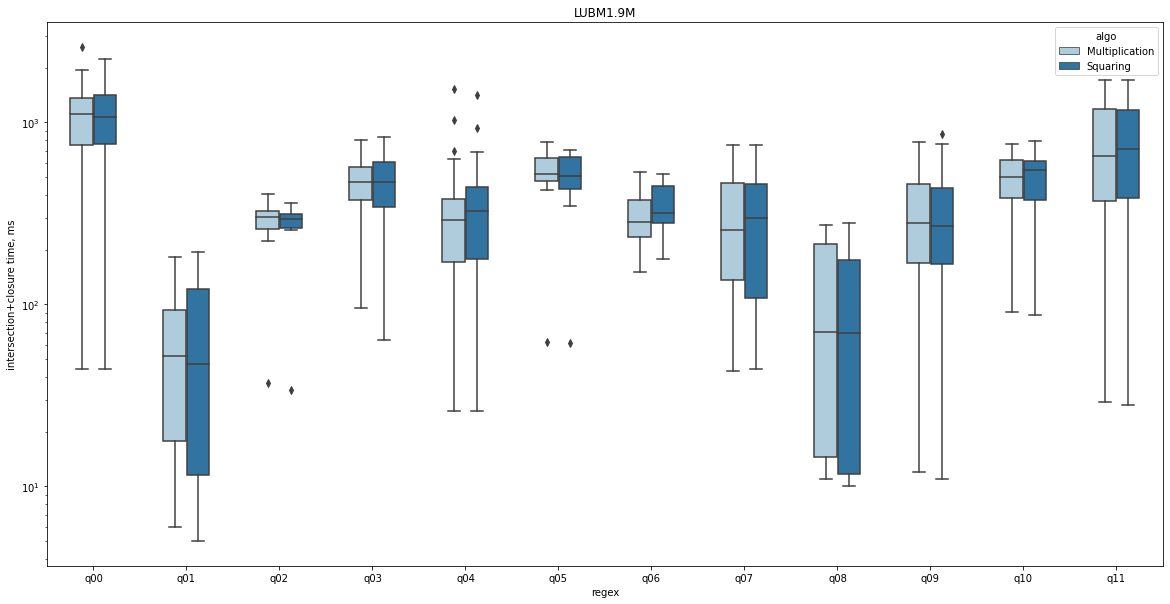

In [165]:
for num in ['300', '500', '1M', '1.5M', '1.9M']:
    df = pandas.read_csv(table_mask.format(num=num))
    
    # Assert that reachable pairs are equal for each algo
    assert df[df['algo'] == 0]['reachable_pairs'].reset_index(drop=True).equals(
        df[df['algo'] == 1]['reachable_pairs'].reset_index(drop=True)
    )
    
    df = df.drop('pairs_time_ms', axis=1)
    boxplot(df)

# Выводы  
На всех графиках со сравнением времени вычисления пересечения и тензорного произведения на разных датасетах, явно заметно, что запросы из группы q00 и q11 вычисляются дольше остальных.

Нет явной разницы между медианой для вычисления транзитивного замыкания матрицы с помощью возведения в квадрат и умножения на матрицу смежности, кроме незначительных отклонений. 
Это можно объяснить тем, что в первом случае более плотные матрицы но меньше операций умножения, когда во втором - много операций умножения, но матрицы сильно разрежены.

Вероятно на больних датасетах разница будет видна лучше, но данные результаты не несут в себе такой информации.